## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the data set

The data set is assigned to a Pandas data frame.
The `BasketDate` is converted from 'str' to 'datetime'.

In [2]:
df = pd.read_csv('data/customer_supermarket.csv', sep='\t', index_col=0, decimal=',')

# convert dates in a suitable format
df['BasketDate'] = pd.to_datetime(df['BasketDate'], dayfirst=True)

# add 'Amount' attribute, useful for some additional features on customer's purchase behaviour
df['Amount'] = df['Sale'] * df['Qta']

C:\Users\tajam\AppData\Local\Temp\ipykernel_13384\2996408569.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BasketDate'] = pd.to_datetime(df['BasketDate'], dayfirst=True)


# Types of attributes and null values

Description of the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471910 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  object        
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
 8   Amount           471910 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 36.0+ MB


Count of null values, for each attribute

In [4]:
df.isnull().sum(axis = 0)

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
Amount                 0
dtype: int64

All the `ProdDescr` missing values are already included in the `CustomerID` ones.
In fact, if we count all the rows where both the attributes are null:

In [5]:
df[df['CustomerID'].isnull() & df['ProdDescr'].isnull()].count()

BasketID           753
BasketDate         753
Sale               753
CustomerID           0
CustomerCountry    753
ProdID             753
ProdDescr            0
Qta                753
Amount             753
dtype: int64

## Analysis of single attributes
### BasketID
Count number of distinct baskets

In [6]:
bid_counts = df['BasketID'].value_counts()
bid_counts.describe()

count    24627.000000
mean        19.162302
std         28.635400
min          1.000000
25%          2.000000
50%         11.000000
75%         24.000000
max        542.000000
Name: count, dtype: float64

### Sale, Qta

We noticed there are 1279 sales with null cost and 9752 with negative quantity.

In [7]:
# rows with null cost
cost_zero = df['Sale'] == 0
df[cost_zero].count()

BasketID           1279
BasketDate         1279
Sale               1279
CustomerID           40
CustomerCountry    1279
ProdID             1279
ProdDescr           526
Qta                1279
Amount             1279
dtype: int64

In [8]:
# rows with negative qta
neg_qta = df['Qta'] < 0
df[neg_qta].count()

BasketID           9752
BasketDate         9752
Sale               9752
CustomerID         8905
CustomerCountry    9752
ProdID             9752
ProdDescr          9305
Qta                9752
Amount             9752
dtype: int64

In [9]:
df[cost_zero & neg_qta].count()

BasketID           668
BasketDate         668
Sale               668
CustomerID           0
CustomerCountry    668
ProdID             668
ProdDescr          221
Qta                668
Amount             668
dtype: int64

We decided to drop these transactions, because they're not relevant for our purposes.

In [10]:
# drop rows with negative quantity
df.drop(df[neg_qta].index, inplace=True)
# drop rows with null cost
df.drop(df[cost_zero].index, inplace=True)

C:\Users\tajam\AppData\Local\Temp\ipykernel_13384\1047208338.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.drop(df[cost_zero].index, inplace=True)


### BasketDate

Some statistics on the dates.

In [11]:
bd_counts = df['BasketDate'].dt.date.value_counts()
print("Min date:", str(min(df['BasketDate'])))
print("Max date:", str(max(df['BasketDate'])))
print("Day with more sales:", str(bd_counts.index[0]))
print("Day with less sales:", str(bd_counts.index[-1]))

Min date: 2010-12-01 08:26:00
Max date: 2011-12-09 12:50:00
Day with more sales: 2011-12-05
Day with less sales: 2010-12-22


C:\Users\tajam\AppData\Local\Temp\ipykernel_13384\59833520.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  a = df.groupby(pd.Grouper(key='BasketDate', freq='M'))['BasketID'].count()


[]

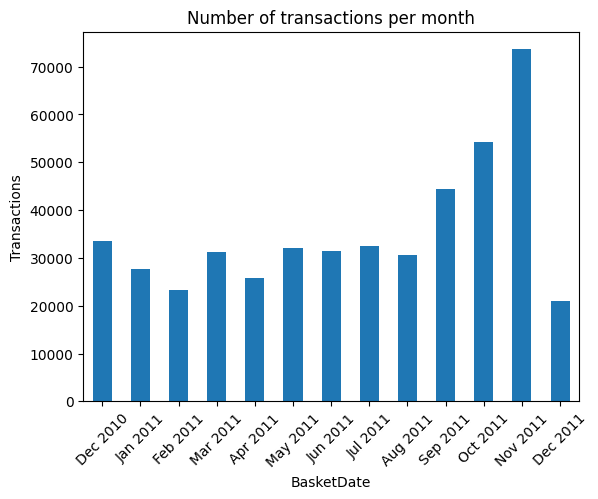

In [12]:
a = df.groupby(pd.Grouper(key='BasketDate', freq='M'))['BasketID'].count()
a.index = a.index.strftime('%b %Y')
aplt = a.plot(kind='bar', title='Number of transactions per month', rot=45)

aplt.set_ylabel('Transactions')
aplt.plot()

### CustomerID
How many transactions each customer made?

count    4338.000000
mean       91.720839
std       228.785054
min         1.000000
25%        17.000000
50%        41.000000
75%       100.000000
max      7847.000000
Name: count, dtype: float64


Text(0, 0.5, 'Transactions')

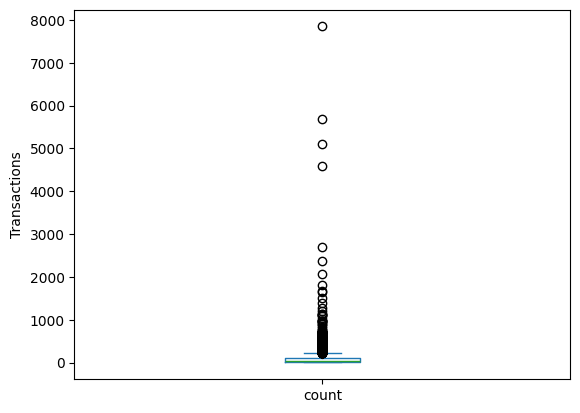

In [13]:
cid_counts = df['CustomerID'].value_counts()
print(cid_counts.describe())
cidplot = cid_counts.plot.box()
cidplot.set_ylabel("Transactions")

As seen before, we have 65080 null values for this attribute.
We removed transactions with null `CustomerID`.

In [14]:
# drop rows with null customerID
df.dropna(subset=['CustomerID'], inplace=True)

# export cleaned dataset for further analysis
df.to_csv(r'data/clean_df.csv', index=True, header=True)


#### CustomerCountry

<Axes: xlabel='CustomerCountry'>

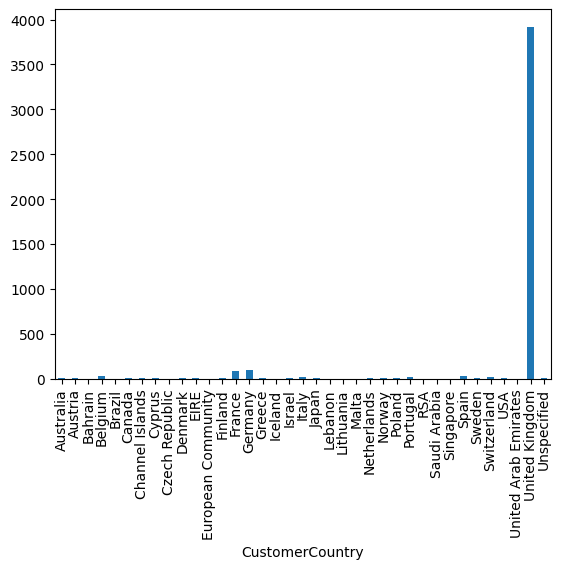

In [15]:
cc_counts = df.groupby(['CustomerCountry', 'CustomerID']).size().groupby(level=0).size()
cc_counts.plot.bar()

### ProdID, ProdDescr

In [16]:
pid_counts = df['ProdID'].value_counts()
print(pid_counts.describe())

best_seller_id = pid_counts.index[0]
best_seller_descr = df.loc[df['ProdID'] == best_seller_id]['ProdDescr'].iloc[0]
print("Best seller: {} ({})".format(str(best_seller_id), str(best_seller_descr)))

worst_seller_id = pid_counts.index[-1]
worst_seller_descr = df.loc[df['ProdID'] == worst_seller_id]['ProdDescr'].iloc[0]
print("Worst seller: {} ({})".format(str(worst_seller_id), str(worst_seller_descr)))

count    3665.000000
mean      108.563438
std       163.762072
min         1.000000
25%        12.000000
50%        49.000000
75%       135.000000
max      2035.000000
Name: count, dtype: float64
Best seller: 85123A (WHITE HANGING HEART T-LIGHT HOLDER)
Worst seller: 62096B (PURPLE/TURQ FLOWERS HANDBAG)


## Correlation

To calculate pairwise correlation, we transformed some attributes into categorical ones. Due to implementation reasons,
`ProdDescr` had to be treated differently from other attributes.
For this reason, we introduced a dictionary: for each string (key) we assigned an incremental identifier (value).

In [17]:
df_corr = df.copy()

df_corr['ProdID'] = df_corr['ProdID'].astype('category').cat.codes
df_corr.sort_values(by=['ProdID'], inplace=True)
obj = {}
idx = 0
s = ""
for index, row in df_corr.iterrows():
    if row['ProdDescr'] != s:
        s = row['ProdDescr']
        obj[s] = idx
        idx += 1

Then we replaced all the descriptions with their associated identifier and this way we proceeded to calculate the
pairwise correlation, represented by a heatmap.

In [18]:
df_corr['ProdDescr'].replace(obj, inplace=True)

df_corr['BasketID'] = df_corr['BasketID'].astype('category').cat.codes
df_corr['BasketDate'] = df_corr['BasketDate'].astype('category').cat.codes
df_corr['CustomerID'] = df_corr['CustomerID'].astype('category').cat.codes
df_corr['CustomerCountry'] = df_corr['CustomerCountry'].astype('category').cat.codes

C:\Users\tajam\AppData\Local\Temp\ipykernel_13384\1051717485.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_corr['ProdDescr'].replace(obj, inplace=True)
C:\Users\tajam\AppData\Local\Temp\ipykernel_13384\1051717485.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_corr['ProdDescr'].repla

<Axes: >

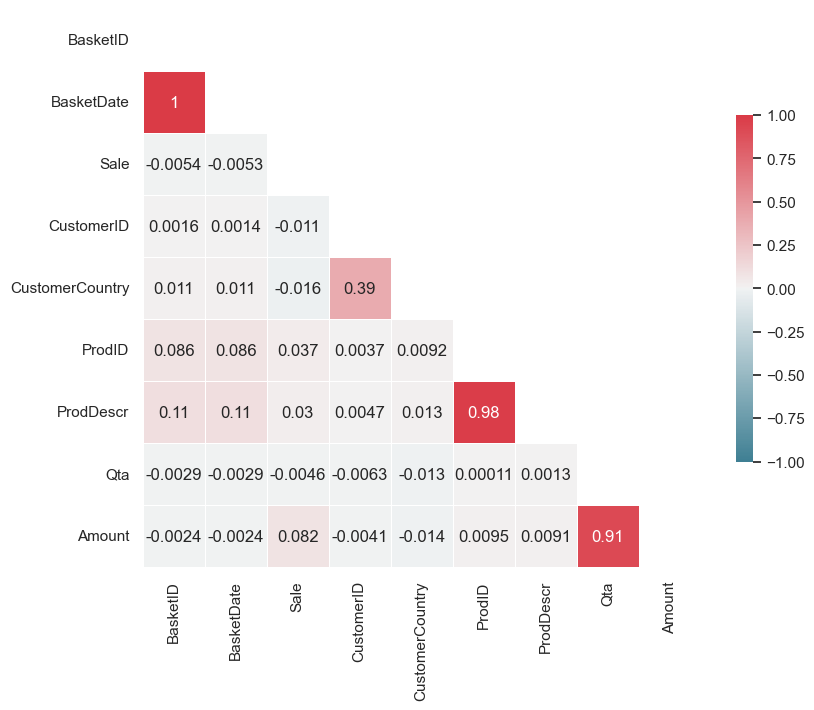

In [19]:
import seaborn as sns

correlation = df_corr.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap,annot=True, vmax=1,vmin=-1,
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

## Requested features
I, Iu, Imax

In [20]:
df_customer = df.groupby('CustomerID').agg(
    I=('ProdID','count'),
    Iu=('ProdID', 'nunique'))

df_customer['Imax'] = (
    df.groupby(['CustomerID', 'BasketID'])['BasketDate']
      .count()
      .groupby('CustomerID')
      .max())

Entropy

In [21]:
pos_amounts = df[df['Amount'] >= 0].copy()
p_sum = pos_amounts.groupby('CustomerID')['Amount'].transform('sum')
probs = pos_amounts['Amount']/p_sum
pos_amounts['Entropy'] = -(probs * np.log(probs)) #ss.entropy(probs)
df_customer['Entropy'] = pos_amounts.groupby('CustomerID')['Entropy'].sum()

## New features

Number of Baskets per customer.

In [22]:
# number of baskets per customer
df_customer['BasketNum'] = df.groupby(['CustomerID', 'BasketID']).size().groupby(level=0).size()

Sum and Average expenditure for each customer.

In [23]:
df_group = df.groupby(['CustomerID','BasketID']).agg(BasketSum=('Amount', 'sum'))
df_group = df_group.groupby('CustomerID').agg(BasketMean=('BasketSum', 'mean'), SumExp=('BasketSum', 'sum'))
df_customer['SumExp'] = df_group['SumExp']
df_customer['AvgExp'] = df_group['BasketMean']

## Analysis of new dataset
Combining the required features with the new ones,
we have created a new dataset, useful for subsequent clustering tasks

In [24]:
df_customer.describe()

,I,Iu,Imax,Entropy,BasketNum,SumExp,AvgExp
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,91.720839,61.501153,32.086445,3.432994,4.272015,2054.270609,419.167327
std,228.785054,85.366768,31.243562,1.287378,7.697998,8989.229895,1796.537828
min,1.000000,1.000000,1.000000,0.000000,1.000000,3.750000,3.450000
25%,17.000000,16.000000,13.000000,2.612131,1.000000,307.415000,178.625000
50%,41.000000,35.000000,23.000000,3.478995,2.000000,674.485000,293.900000
75%,100.000000,77.000000,42.000000,4.327716,5.000000,1661.740000,430.113750
max,7847.000000,1787.000000,542.000000,8.335226,209.000000,280206.020000,84236.250000


<Axes: >

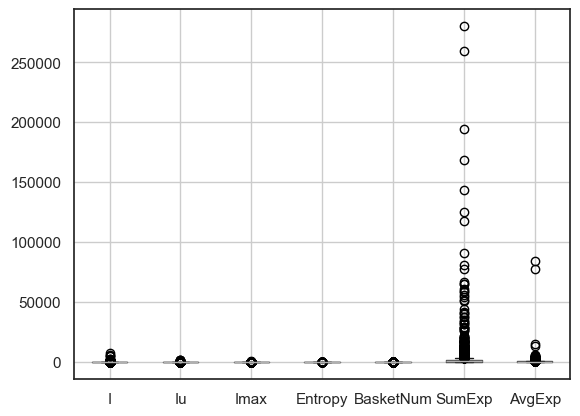

In [25]:
df_customer.boxplot()

## Remove outliers from the new dataset
We exploited the metric of Z-Score.

In [26]:
# use z-score to remove outliers
from scipy.stats import zscore
z_scores = zscore(df_customer)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df_customer[filtered_entries]

new_df.to_csv(r'data/new_df.csv', index=True, header=True)

new_df.describe()

,I,Iu,Imax,Entropy,BasketNum,SumExp,AvgExp
count,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000
mean,70.315032,52.372812,28.871014,3.350154,3.579238,1327.559716,354.999266
std,86.624853,53.545089,22.914839,1.222166,3.794688,2058.227242,329.019302
min,1.000000,1.000000,1.000000,0.000000,1.000000,3.750000,3.450000
25%,16.000000,15.000000,12.000000,2.577585,1.000000,300.935000,176.802500
50%,39.000000,33.000000,23.000000,3.411811,2.000000,640.760000,287.035000
75%,90.000000,71.000000,39.000000,4.220842,4.000000,1521.170000,417.920000
max,756.000000,315.000000,125.000000,6.334695,27.000000,28754.110000,4932.130000


<Axes: >

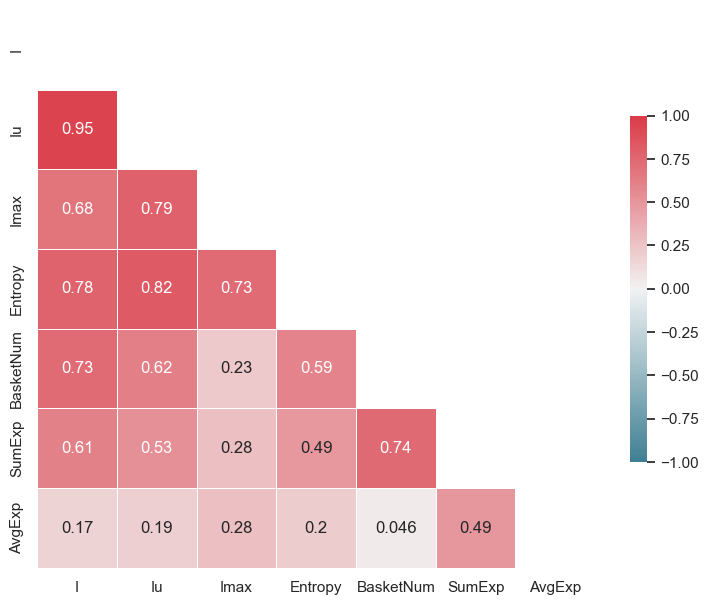

In [27]:
correlation = new_df.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fnew, axnew = plt.subplots(figsize=(9,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap,annot=True, vmax=1,vmin=-1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})